# Assignment: Video Quality Inference

To this point in the class, you have learned various techniques for leading and analyzing packet captures of various types, generating features from those packet captures, and training and evaluating models using those features.

In this assignment, you will put all of this together, using a network traffic trace to train a model to automatically infer video quality of experience from a labeled traffic trace.

## Part 1: Warmup

The first part of this assignment builds directly on the hands-on activities but extends them slightly.

### Extract Features from the Network Traffic

Load the `netflix.pcap` file, which is a packet trace that includes network traffic. 

Click [here](https://github.com/noise-lab/ml-systems/blob/main/docs/notebooks/data/netflix.pcap) to download `netflix.pcap`.


In [1]:
import pandas as pd
from netml.pparser.parser import PCAP

pcap = PCAP("netflix.pcap")
pcap.pcap2pandas()
ndf = pcap.df
ndf.head(20)

,datetime,dns_query,dns_resp,ip_dst,ip_dst_int,ip_src,ip_src_int,is_dns,length,mac_dst,mac_dst_int,mac_src,mac_src_int,port_dst,port_src,protocol,time,time_normed
0,2018-02-11 08:10:00,"(fonts.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,55697.0,UDP,1518358200.534682,0.000000
1,2018-02-11 08:10:00,"(fonts.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,77,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,59884.0,UDP,1518358200.534832,0.000150
2,2018-02-11 08:10:00,"(googleads.g.doubleclick.net.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,87,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,61223.0,UDP,1518358200.539408,0.004726
3,2018-02-11 08:10:00,"(googleads.g.doubleclick.net.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,87,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,58785.0,UDP,1518358200.541204,0.006522
4,2018-02-11 08:10:00,"(ytimg.l.google.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,78,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,51938.0,UDP,1518358200.545785,0.011103
5,2018-02-11 08:10:00,"(r4---sn-gxo5uxg-jqbe.googlevideo.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,96,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,20949.0,UDP,1518358200.547036,0.012354
6,2018-02-11 08:10:00,"(ssl.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,75,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,58025.0,UDP,1518358200.547156,0.012474
7,2018-02-11 08:10:00,"(www.google.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,74,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,15895.0,UDP,1518358200.547249,0.012567
8,2018-02-11 08:10:00,"(pagead46.l.doubleclick.net.,)","(216.58.213.162,)",192.168.43.72,3.232247e+09,128.93.77.234,2.153598e+09,True,96,e4:ce:8f:01:4c:54,251575813622868,a0:ce:c8:0d:2b:a7,176809980013479,61223.0,53.0,UDP,1518358200.853950,0.319268
9,2018-02-11 08:10:00,"(www.gstatic.com.,)",None,128.93.77.234,2.153598e+09,192.168.43.72,3.232247e+09,True,75,a0:ce:c8:0d:2b:a7,176809980013479,e4:ce:8f:01:4c:54,251575813622868,53.0,18154.0,UDP,1518358200.853970,0.319288


### Identifying the Service Type

Use the DNS traffic to filter the packet trace for Netflix traffic.

In [3]:
import dnslib

NF_DOMAINS = (["nflxvideo", 
              "netflix", 
              "nflxso", 
              "nflxext"])

In [2]:
#from exercise 3
nfre = '|'.join(NF_DOMAINS)
nf_queries = ndf[ndf['Info'].str.contains(nfre, regex=True, na=False) & ndf['Protocol'].str.contains('DNS')]
nf_queries.head(4)

NameError: name 'NF_DOMAINS' is not defined

### Generate Statistics

Generate statistics and features for the Netflix traffic flows. Use the `netml` library or any other technique that you choose to generate a set of features that you think would be good features for your model. 

In [ ]:
import netml
import matplotlib.pyplot as plt

In [ ]:
pcap = PCAP('netflix.pcap', flow_ptks_thres=10)

pcap.pcap2flows()

# Extract inter-arrival time features
pcap.flow2features('IAT', fft=False, header=False)

In [ ]:
## Packet length
packet_len = netflix_traffic["length"]

# Compute stats
min_val = packet_len.min()
max_val = packet_len.max()
mean_val = packet_len.mean()
median_val = packet_len.median()

print(f"Min: {min_val}")
print(f"Max: {max_val}")
print(f"Mean: {mean_val}")
print(f"Median: {median_val}")

Min: 70
Max: 178
Mean: 99.66071428571429
Median: 97.0


/var/folders/jf/7swv03bx5yzc5m92w3c549hr0000gn/T/ipykernel_24491/196182386.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  netflix_traffic['cdf'] = netflix_traffic['length'].rank(method = 'max', pct = True)


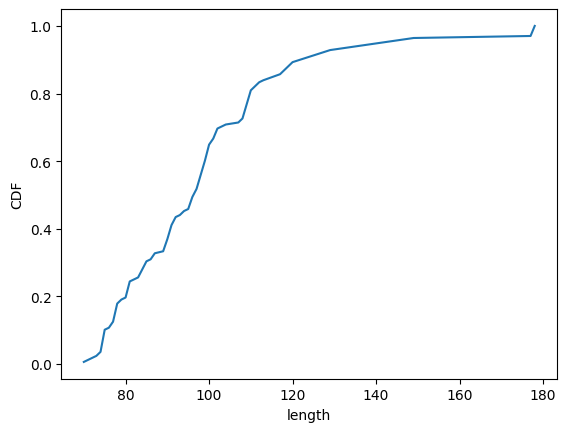

In [ ]:
#cdf for packet len
netflix_traffic['cdf'] = netflix_traffic['length'].rank(method = 'max', pct = True)
netflix_traffic.sort_values('length').plot(x = 'length', y = 'cdf', grid = False, legend = None)
plt.ylabel('CDF')
plt.show()

In [ ]:
#time statistics


In [ ]:
#Generate feature vector


**Write a brief justification for the features that you have chosen.**

### Inferring Segment downloads

In addition to the features that you could generate using the `netml` library or similar, add to your feature vector a "segment downloads rate" feature, which indicates the number of video segments downloaded for a given time window.

Note: If you are using the `netml` library, generating features with `SAMP` style options may be useful, as this option gives you time windows, and you can then simply add the segment download rate to that existing dataframe.

In [ ]:
##TODO: figure out stats for QoE from textbook

## Part 2: Video Quality Inference

You will now load the complete video dataset from a previous study to train and test models based on these features to automatically infer the quality of a streaming video flow.

For this part of the assignment, you will need two pickle files, which we provide for you by running the code below:

```

!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

```

### Load the File

Load the video dataset pickle file.

In [ ]:
import gdown
!gdown 'https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS' -O netflix_session.pkl
!gdown 'https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI' -O video_dataset.pkl

Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1N-Cf4dJ3fpak_AWgO05Fopq_XPYLVqdS

but Gdown can't. Please check connections and permissions.
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1PHvEID7My6VZXZveCpQYy3lMo9RvMNTI

but Gdown can't. Please check connections and permissions.


### Clean the File

1. The dataset contains video resolutions that are not valid. Remove entries in the dataset that do not contain a valid video resolution. Valid resolutions are 240, 360, 480, 720, 1080.

2. The file also contains columns that are unnecessary (in fact, unhelpful!) for performing predictions. Identify those columns, and remove them.

**Briefly explain why you removed those columns.**

### Prepare Your Data

Prepare your data matrix, determine your features and labels, and perform a train-test split on your data.

### Train and Tune Your Model

1. Select a model of your choice.
2. Train the model using your training data.

### Tune Your Model

Perform hyperparameter tuning to find optimal parameters for your model.

### Evaluate Your Model

Evaluate your model accuracy according to the following metrics:

1. Accuracy
2. F1 Score
3. Confusion Matrix
4. ROC/AUC

## Part 3: Predict the Ongoing Resolution of a Real Netflix Session

Now that you have your model, it's time to put it in practice!

Use a preprocessed Netflix video session to infer **and plot** the resolution at 10-second time intervals.